# Install neccessary packages 

In [ ]:
""" %pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow
 """

## Import packages

In [4]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


## Set up functions
in the end I did not use the function to load csv files for the weather stations. 

In [11]:
# Function to load the Dublin bus gz files 
def load_Files(direc, files, comtype):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv(direc + f, compression=comtype, delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

def crackit_open(busFile):
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile,  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files('./Data/Bus/Gz/', DBfiles, 'gzip'), copy = False)
    return df

def shapiro_test(x):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    color = 'blue'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val
import plotly.express as px
def plotly_scatterplot(df1, col1=''):
    df1 = df1[df1["LineID"]==col1]
    #build scatter using Plotly Express
    fig = px.scatter_3d(df1, x=df1['LonWGS84'] , y=df1['LatWGS84'], z=df1['Hour'], color=df1['Colour'])

    #update visual: set size and opacity of markers
    fig.update_traces(marker=dict(size=5, opacity=0.6))

    #show visual
    fig.show()

def custom_scatterplot(df1, col1=''):
    df1 = df1[df1["LineID"]==col1]
    f = plt.figure()
    f, ax = plt.subplots(figsize=(11.5, 11.5))
    ax = f.add_subplot(projection='3d')
    ax.scatter(df1['LonWGS84'], df1['LatWGS84'], df1['Hour'], alpha=0.6, color=df1['Colour'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Hour')
    dcol = str(col1)
    plt.savefig('./Images/Img_' + dcol + '_Longitude_Latitude_Hour.svg')
    df1.to_parquet('./Data/Bus/LineID_' + dcol + '.parquet')
    
    
def custom_barplot(df1, col1=''):
    if len(df1[col1]) > 5000: # added this to the function because of warnings about the size of data being used with shapiro test
            sampleSize = 5000
    else:
        sampleSize = len(df1[col1])
    df1 = df1.sample(sampleSize) #shapiro test is unreliable over 5000 https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test and performance reasons
    f, ax = plt.subplots(2,2, figsize=(11.5, 11.5))
    ax = ax.reshape(-1)
    df1[col1].plot(ax=ax[0], kind='hist')
    ax[0].set_title('Histogram of {}'.format(col1))
    df1[col1].plot(ax=ax[1], kind='kde')
    ax[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df[col1], plot=plt)
    ax[2].set_title('QQ Plot of {}'.format(col1))
    df1[col1].plot(ax=ax[3], kind='box')
    ax[3].set_title('Box Plot of {}'.format(col1))
    status, color, p_val = shapiro_test(df1[col1]) 
    f.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val), color=color, fontsize=12)

def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

def load_csv_Files(direc, files):

    for f in files:
        # need to get number of rows to skip 
        temp=pd.read_csv(direc + f,sep='^',header=None,prefix='X')
        temp2=temp.X0.str.split(',',expand=True)
        del temp['X0']
        temp=pd.concat([temp,temp2],axis=1)
        cols = list(range(0,temp.shape[1]))

        print(f)
        yield pd.read_csv(direc + f,  delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, usecols=cols, na_values='NAN')

## Ensure that the folder structure is present in the workspace

In [4]:
if os.path.exists('./Data'):
    print('Data folder exists')

if os.path.exists('./Data/Bus'):
    print('Bus Data folder exists')
else:
    os.makedirs('./Data/Bus')

if os.path.exists('./Data/MetEirrean/'):
    print('Weather data folder exists')
else:
    os.makedirs('./Data/MetEirrean/')

if os.path.exists('./Zips/MetEirrean'):
    print('Weather folder exisits')
else:
    os.makedirs('./Zips/MetEirrean/')

if os.path.exists('./Images/'):
    print('Images folder exists')
else:
    os.makedirs('./Images/')



## Download the Dublin Bus data 
    from https://data.gov.ie/organization/dublin-city-council?tags=Transport+and+Infrastructure
    Decompress the zip file into the zips/Bus folder
    Use a generator to load the data into pandas data frame https://pandasninja.com/2019/04/how-to-read-lots-of-csv-files-easily-into-pandas/#:~:text=How%20to%20read%20lots%20of%20csv%20files%20easily,need%20...%204%204.%20Leverage%20regular%20expressions%20

## Loop through the gz files and decompress them in to the Data/Bus folder

In [ ]:
# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/CleanedBusData.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/CleanedBusData.parquet')
    if os.path.exists('./Data/WeatherandBusData.parquet'):
        print('Weather and bus data combined exists')
        mdf = pd.read_parquet('./Data/WeatherandBusData.parquet')
elif os.path.exists('./Zips/Bus/DublinBusdata.zip'):
    print("Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open")
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')

df = df.sample(20000000)
### Read the Bus data in to a Pandas dataframe - done

Parquest file exists, means the Bus data has been downloaded already 


Weather and bus data combined exists


### Check for missing and have a brief look at the data 

The Temp_df contains the output of a pandas description function. The missing_ df contains the output of function which counts missing values in a column.

In [ ]:
temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)

## Remove unwanted columns 
At this stage we will drop Direction as it has only value 0
And we will drop TimeFrame as it relates to the time that the data was collected and its information is duplicated in the TimeStamp field


In [ ]:
if 'Direction' in df.columns:
    df = df.drop(['Direction'], axis='columns')
if 'TimeFrame' in df.columns:
    df = df.drop(['TimeFrame'], axis='columns')
""" if {'VehicleJourneyID', 'JourneyPatternID'}.issubset(df.columns):  
    df['VehicleJourneyID'] = df['JourneyPatternID'] + '_' + df['VehicleJourneyID'].astype('str')
    df = df.drop(['JourneyPatternID','VehicleJourneyID'], axis='columns') """

In [ ]:

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)

### Drop nas and duplicates - there are no duplicates but there are na's 
This drops the rows with empty LineID and empty Journey Pattern ID values and the times that bus is not reporting a bus stop id. The journey pattern id is an identifier for the particular bus route 

In [ ]:
df = df.dropna() 
df = df.drop_duplicates()

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)



# Exploratory data analysis on the Bus Data
## Display the shape and types of data in the Bus data frame

In [ ]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))
print("The types of columns are:")
display(df.dtypes)

### Describe the numerical data in the Bus data set
#### Display the summary Data about the Numerical columns

In [ ]:
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType'] # type: ignore
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
display(summary_df) # Numerical Data

### Set the Numerical and Categorical columns

In [ ]:
# Getting the list of column Types


CategoricalColumns = ['AtStop','BlockID','Congestion','Operator','StopID','VehicleID',  'VehicleJourneyID']
NumericalColumns = [ 'Delay', 'LatWGS84', 'LonWGS84']
DateColumns = list(set(list(df.select_dtypes([np.datetime64]).columns)))
ColumnsToExclude = ('Month', 'Year', 'Direction')



CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude)-set(DateColumns))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude)-set(DateColumns))

print(CategoricalColumns)
print(NumericalColumns)
print(DateColumns)


b: Describe the categoric data - done

In [ ]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat)

## Add time columns to the Bus Data

In [ ]:
# Deal with the timestamp and make it human readable and i will use this to merge datasets later 
# we might be using a saved data set from before, check that the Timestamp is in the dataset
if 'Timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
    df['Day'] = df['datetime'].dt.day
    df['Hour'] = df['datetime'].dt.hour
    df['Minute'] = df['datetime'].dt.minute
    df['DayofWeek'] = df['datetime'].dt.day_of_week
    df = df.drop(['Timestamp',  'datetime'], axis='columns')

In [ ]:
# Check the outcome of adding time and day data
df.head()

In [ ]:
# save work done so far 
df.to_parquet('./Data/CleanedBusData.parquet')

# Display Histograms from the Data set

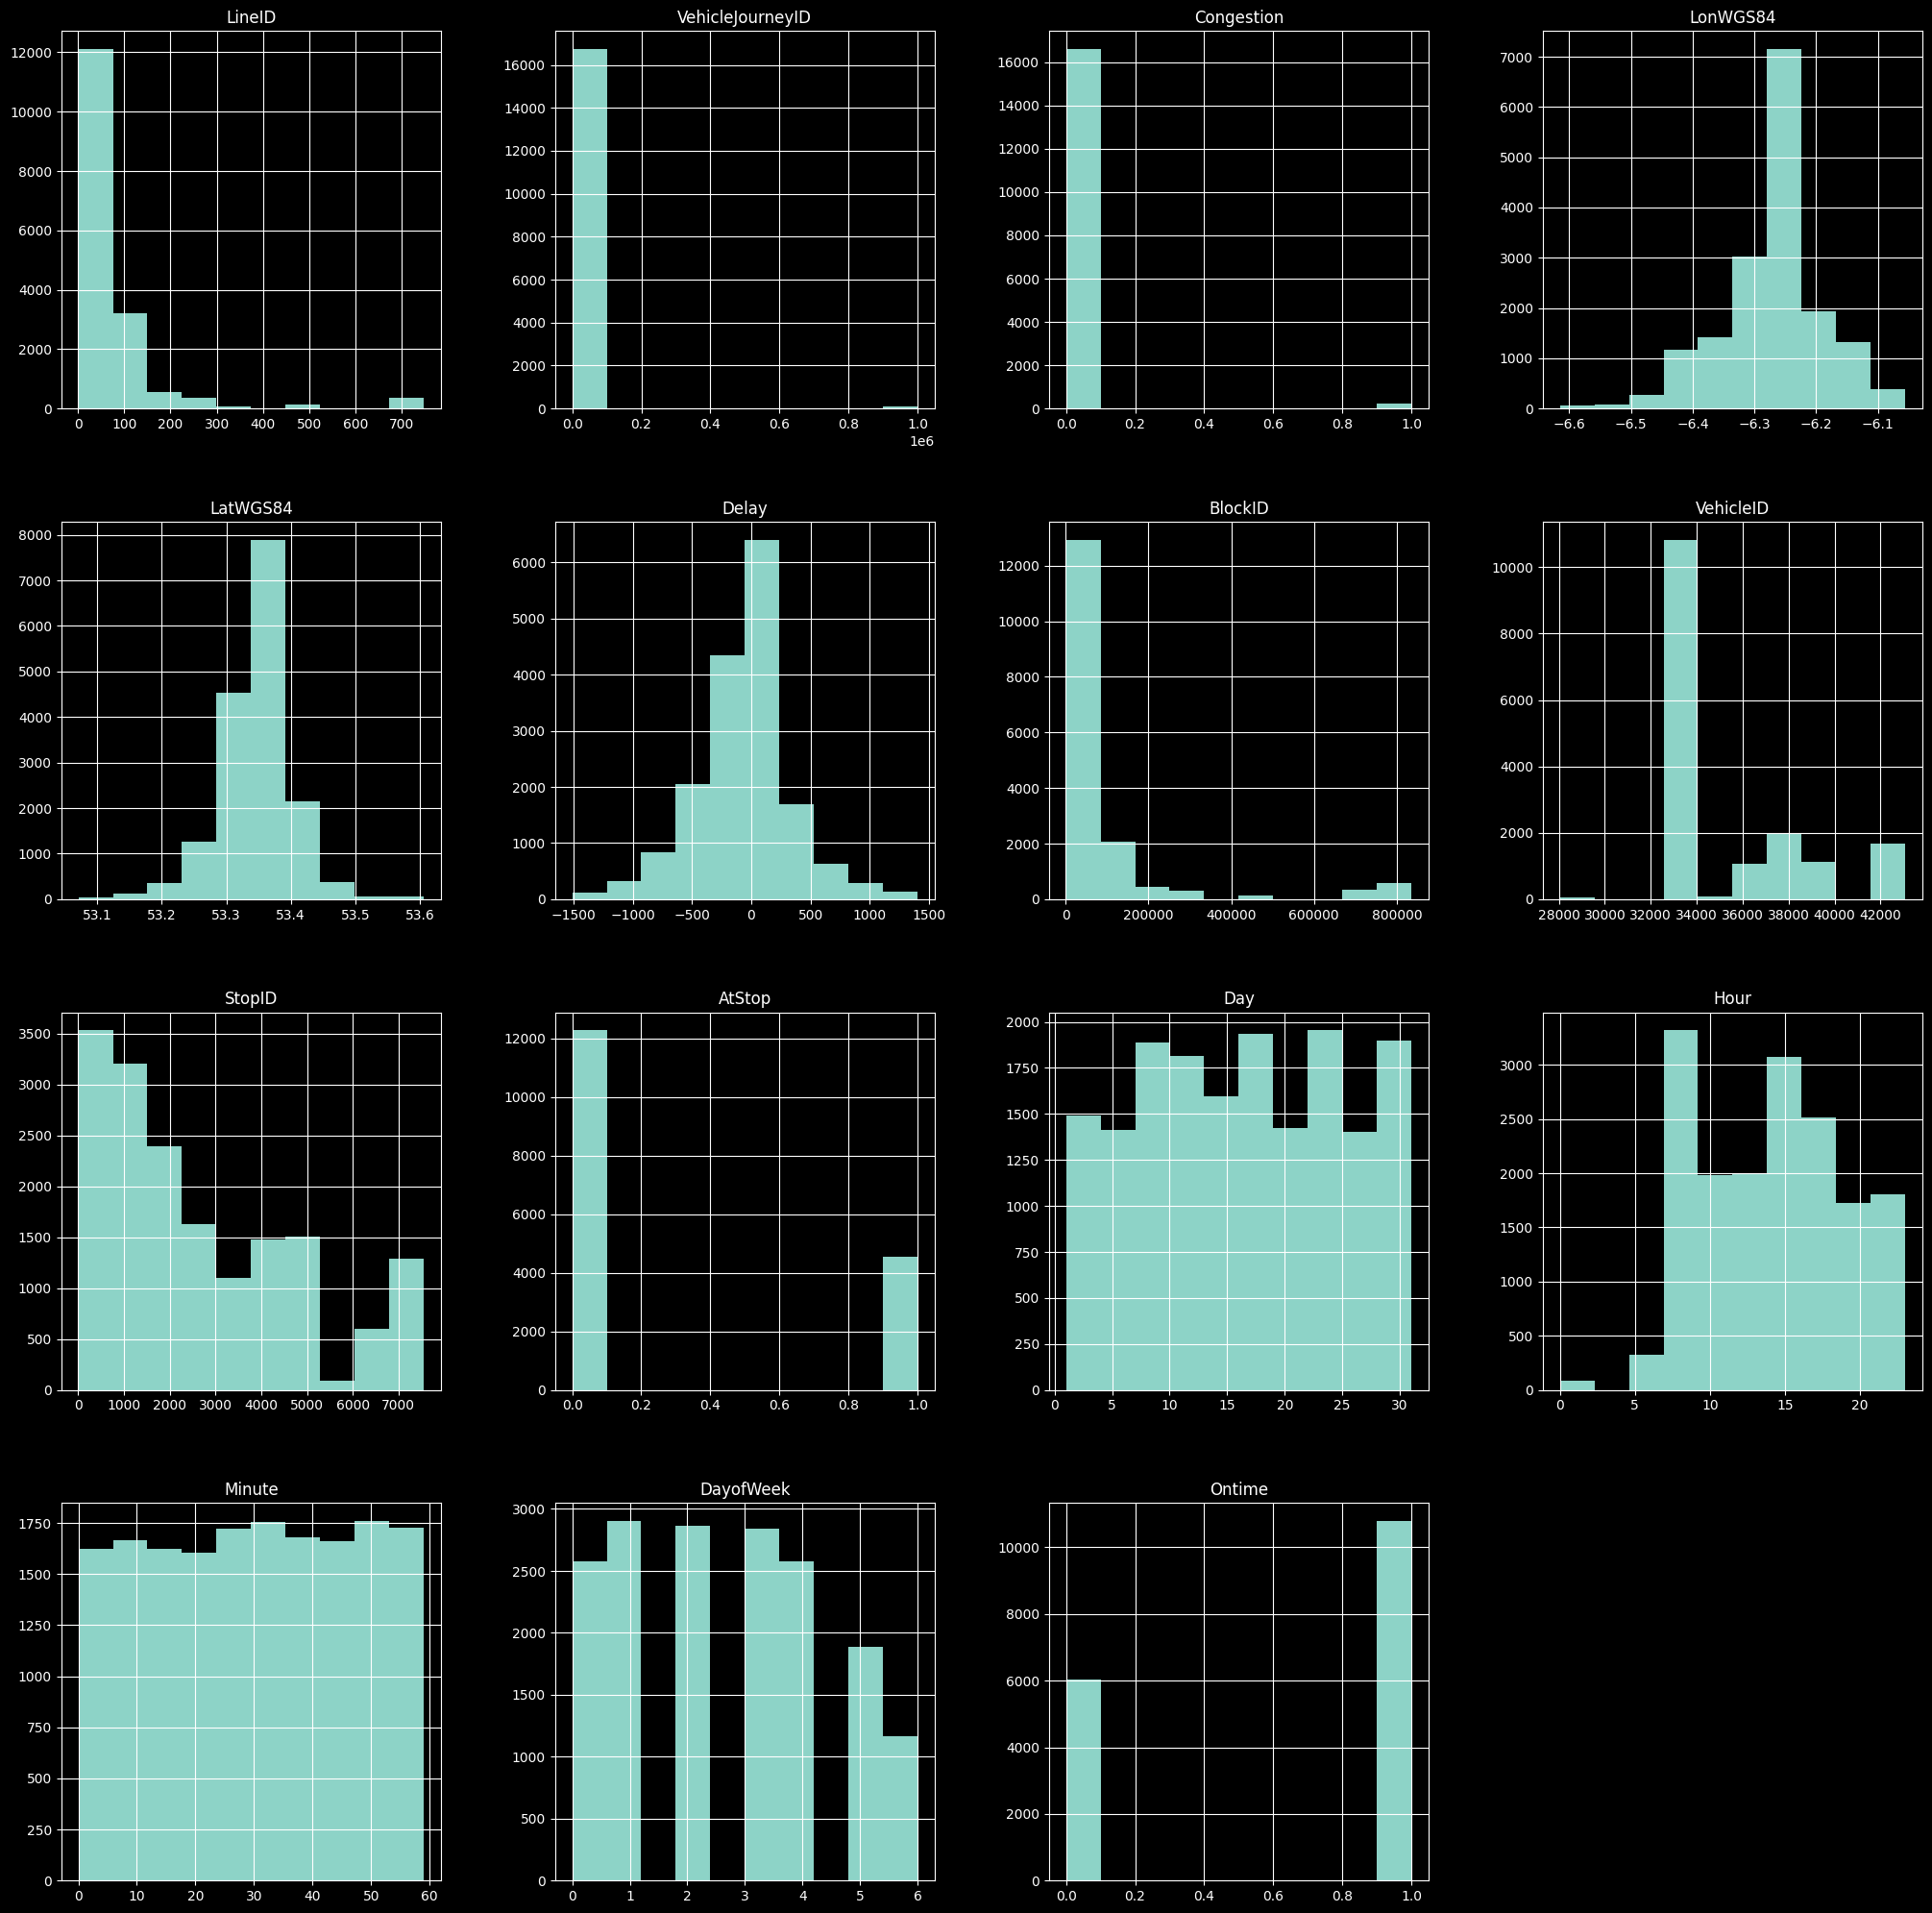

In [7]:
%matplotlib inline
df.hist(figsize=(25,25));
plt.savefig('./Images/Img_1_BusDataframe_histogram.svg')

In [ ]:
df.hist(['LineID'], bins= 66, figsize=(8,8))
plt.savefig('./Images/Img_1a_lineID_histogram.svg')

In [ ]:
df.hist(['Delay'], bins= 100, figsize=(8,8))
plt.savefig('./Images/Img_1b_Delay_histogram.svg')

## Display boxplots of some of the numeric data

Note we have outliers in the Delay value for one bus operator, on a Friday the 11'th of January, these look like a mistake as 120,000 seconds is equal to circa 1.4 days, anything above 20,000 seconds is circa 5.5 hours late.

In [ ]:
sns.set(color_codes=True)
sns.catplot(data=df, x='Operator', y = 'Delay' ,   kind='box', height=12, aspect=1.618);
plt.savefig('./Images/Img_2_Operator_Delay.svg')

In [ ]:
sns.catplot(data=df, x='DayofWeek', y = 'Delay' ,   kind='box', height=12, aspect=1.618);
plt.savefig('./Images/Img_3_DayofWeek_Delay.svg')

In [ ]:
sns.catplot(data=df, x='Day', y = 'Delay' ,   kind='box', height=12, aspect=1.618);
plt.savefig('./Images/Img_4_Day_Delay.svg')

Set the Upper and Lower bounds based on IRQ and also using Z scores to filter the data later 


In [ ]:
display(temp_df.head(7))
Q1 = temp_df.iat[6,4]
Q3 = temp_df.iat[6,6]
print(Q1, Q3)

IQR = Q3 - Q1
uppr = (Q3+(1.5*IQR))
lwr = (Q1-(1.5*IQR))

print(lwr, uppr)
z = np.abs(stats.zscore(df['Delay']))
df['Zscore'] = z

#### Box plots of the Buses that are later than the upper bound 684 seconds

In [ ]:
df_late = df[df['Delay'].astype('int64') > uppr] # buses 2 hours late :)

if df_late.shape[0] > 0:
    sns.catplot(data=df_late, x='LineID', y = 'Delay' ,   kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_5_LineID_Delay_Late.svg')
    sns.catplot(data=df_late, x='Hour', y = 'Delay' , hue='Operator' , kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_6_Hour_Delay_Late.svg')
    sns.catplot(data=df_late, x='Day', y = 'Delay' , hue='Operator',   kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_7_Day_Delay_Late.svg')
    df_late.to_parquet('./Data/lateOutlierBusData.parquet')

#### Box plots of the Buses that are earlier than the lower bound -836 seconds

In [ ]:
df_early = df[df['Delay'].astype('int64') < lwr] 
if df_early.shape[0] > 0:
    sns.catplot(data=df_early, x='LineID', y = 'Delay' ,   kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_8_LineID_Delay_Early.svg')
    sns.catplot(data=df_early, x='Hour', y = 'Delay' , hue='Operator' , kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_9_Hour_Delay_Early.svg')
    sns.catplot(data=df_early, x='Day', y = 'Delay' , hue='Operator',   kind='box', height=12, aspect=1.618);
    plt.savefig('./Images/Img_10_Day_Delay_Early.svg')
    df_early.to_parquet('./Data/EarlyOutlierBusData.parquet')

### Remove outliers from the Delay 
Decided to focus the data set on buses that have a Z score less than or equal to 3, went with the zscore as it removed least rows

In [ ]:
print("old shape: ", df.shape)
# df = df[df['Delay'].astype('int64') <= uppr]
# df = df[df['Delay'].astype('int64') >= lwr]
df = df[df['Zscore'] <= 3]
df = df.drop(['Zscore'], axis='columns')
print("New Shape: ", df.shape)


In [ ]:
# save work done so far 
df.to_parquet('./Data/CleanedBusData.parquet')

In [ ]:
sns.catplot(data=df, x='Operator', y = 'Delay' , kind='box', height=12, aspect=1.618);
plt.savefig('./Images/Img_11_Operator_Delay.svg')

In [ ]:
sns.catplot(data=df, x='DayofWeek', y = 'Delay' , kind='box', height=12, aspect=1.618);
plt.savefig('./Images/Img_12_DayofWeek_Delay.svg')

We can see from the Correlation matrix that none of the variables in the Bus data is stronlgy correlated to either Delay or Congestion variables

In [ ]:
c_df = df.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(20,15))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="YlGnBu", annot=True)
plt.savefig('./Images/Img_13_BusDataframeCorHeatmap.svg')
plt.show()

## Display Numerical Columns


In [ ]:
if len(df) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(df)
for f in NumericalColumns:
    custom_barplot( df1=df.sample(sampleSize), col1=f)

In [ ]:
df['Colour'] = df['Delay'].apply(lambda x: 'Black' if (x < -300)  else 'Red' if  (x > 300)  else 'Yellow')

In [ ]:
df['Ontime'] = df['Delay'].apply(lambda x: 0 if (x < -300) or (x > 300) else 1)


In [ ]:
# save work done so far 
df.to_parquet('./Data/CleanedBusData.parquet')

In [ ]:
df = pd.read_parquet('./Data/CleanedBusData.parquet')

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['LineID'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Bus Route')
#plt.savefig('./Images/Img_14_Delay_BusRoute.svg')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Hour'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Hour of Day')
#plt.savefig('./Images/Img_15_Delay_HourofDay.svg')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Day'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Day of Month')
#plt.savefig('./Images/Img_16_Delay_DayofMonth.svg')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['DayofWeek'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Day of Week')
#plt.savefig('./Images/Img_17_Delay_DayofWeek.svg')
plt.show()

### A look at Congestion variable

In [ ]:

df.hist(by = 'Congestion', column= 'Hour', figsize=(15,12));
plt.savefig('./Images/Img_18_Congestion_Hour.svg')


In [ ]:

df.hist(by = 'Congestion', column= 'DayofWeek',figsize=(15,12));
plt.savefig('./Images/Img_19_Congestion_DayofWeek.svg')


In [ ]:
df.hist(by = 'Congestion', column= 'Day',figsize=(15,12));
plt.savefig('./Images/Img_20_Congestion_Day.svg')

In [ ]:
df.hist(by = 'Congestion', column= 'Operator',figsize=(15,12),sharey=True);
plt.savefig('./Images/Img_21_Congestion_Operator.svg')

### Individual Bus Routes displayed
Black if the bus is early, Red if it is late and yellow if it is within a 5 minute window of its scheduled time

In [13]:

busRoutes = sorted(df['LineID'].unique())

w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'LineID',
    )

i = interactive(custom_scatterplot, df1 =fixed(df), col1=w1)
#i = interactive(plotly_scatterplot, df1 =fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)


# Download the weather station details https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
## Download the weather stations csv file

In [ ]:
df.to_parquet('./Data/CleanedBusData.parquet')


In [ ]:
df.shape

In [ ]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv'


### Load the weather statio details for Dublin
Get the information for the Dublin weather stations -done

In [ ]:
weatherStations = pd.read_csv(url)
weatherStations = weatherStations[weatherStations['county'].str.contains('Dublin')]
weatherStations.head(10)
dublinStations = weatherStations[["station name", "name"]]
dublinStations.columns = [x.strip().replace(' ', '') for x in dublinStations.columns]

### Loop through this data and download the hourly weather data into Data/Weather folder - done

In [ ]:
for rows in dublinStations.itertuples():
    # get hourly weather data
    url = "http://cli.fusio.net/cli/climate_data/webdata/hly" + str(rows.stationname) + ".zip"
    print(url)
    dest = './Zips/MetEirrean/hly' + str(rows.stationname) + ".zip"
    try:
        weatherFile = rq.urlretrieve(url, dest)
        continue
    except Exception:
        print('No file exists')  
    # # get the daily weather data - ONLY USING THE HOURLY DATA FOR NOW
    # url = "http://cli.fusio.net/cli/climate_data/webdata/dly" + str(rows.stationname) + ".zip"
    # print(url)
    # dest = './Zips/MetEirrean/dly' + str(rows.stationname) + ".zip"
    # try:
    #     weatherFile = rq.urlretrieve(url, dest)
    #     continue
    # except Exception:
    #     print('No file exists')  

In [ ]:
import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
files = os.listdir('./Zips/MetEirrean/')
WDfiles = [f for f in files if f.startswith('hly')]
for f in WDfiles:
    fp = './Zips/MetEirrean/' + f
    with zip.ZipFile(fp,  mode='r') as arc: 
        arc.extractall('./Data/MetEirrean/')



### Read the weather data and load in the hourly weather data between the min and max dates - done

In [ ]:
Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')



Phoenix_wdf['datetime'] = pd.to_datetime(Phoenix_wdf['date'])
Phoenix_wdf['Year'] = Phoenix_wdf['datetime'].dt.year
Phoenix_wdf['Month'] = Phoenix_wdf['datetime'].dt.month
Phoenix_wdf['Day'] = Phoenix_wdf['datetime'].dt.day
Phoenix_wdf['Time'] = Phoenix_wdf['datetime'].dt.time
Phoenix_wdf['Hour'] = Phoenix_wdf['datetime'].dt.hour
Phoenix_wdf['Minute'] = Phoenix_wdf['datetime'].dt.minute
Phoenix_wdf['DayofWeek'] = Phoenix_wdf['datetime'].dt.day_of_week
#Filter the weather data to January 2013
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Year'] == 2013]
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Month'] == 1]
# remove unwanted columns, the indicator columns all show 0, the other vappr wetb and dewpt are all closely related to temp
Phoenix_wdf = Phoenix_wdf.drop(['date','Year','Month', 'ind', 'ind.1', 'ind.2', 'vappr', 'wetb', 'dewpt','datetime', 'Time'], axis='columns')
Phoenix_wdf = Phoenix_wdf.astype({"rain": float})
Phoenix_wdf = Phoenix_wdf.astype({"temp": float})
Phoenix_wdf = Phoenix_wdf.astype({"rhum": float})
Phoenix_wdf = Phoenix_wdf.astype({"msl": float})

Phoenix_wdf.dtypes

In [ ]:
Phoenix_wdf.head()

# Brief look at corelated variables in the weather data.

Temperature is strongly corelated to wetb, dewpt and vappr measurements meaning that multicollinearity might be an issue with any regression models

In [ ]:
sns.pairplot(Phoenix_wdf);
plt.savefig('./Images/Img_22_WeatherDistributionPlot.svg')

In [ ]:
c_wd = Phoenix_wdf.corr('pearson', numeric_only=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_wd, cmap="YlGnBu", annot=True)
plt.savefig('./Images/Img_23_WeatherCorHeatmap.svg')
plt.show()


In [ ]:
#join weather and bus 
mdf = pd.merge(df, Phoenix_wdf, how='inner', on=['DayofWeek','Day', 'Hour', 'Minute'])


In [ ]:
mdf.head()


In [ ]:
mdf.shape

In the image below we can see that there seems to be more delayed buses in the suburbs of Dublin than there are in the center

Black if the bus is early, Red if it is late and yellow if it is within a 5 minute window of its scheduled time

In [42]:
import plotly.express as px
#build scatter using Plotly Express
fig = px.scatter_3d(mdf, x='LonWGS84', y='LatWGS84', z='Hour')
#update visual: set size and opacity of markers
fig.update_traces(marker=dict(size=5, opacity=0.6,color=mdf['Colour'].str.lower(), line=dict(width=0.5, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), height=600, width=800)

#show visual
fig.show()

In [61]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(x=mdf['LonWGS84'], y=mdf['LatWGS84'], alpha=0.25,  c=mdf['Colour'] )
plt.title('Buses by schedule status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('./Images/Img_24_BusbySchedule.svg')
plt.show();

### Correlation Plot of Bus and Weather data

In [ ]:
c_df = mdf.corr('pearson', numeric_only=True)
ffig, ax = plt.subplots(figsize=(20,15))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="YlGnBu", annot=True)
plt.savefig('./Images/Img_25_MergedCorHeatmap.svg')
plt.show()

In [ ]:
sns.pairplot(mdf)


### display histogram of the new data set

In [ ]:
mdf.hist(figsize=(25,25));
plt.savefig('./Images/Img_27_MergedDistPlot.svg')

In [ ]:
custom_barplot( df1=mdf.sample(5000), col1='Delay')

### Seaborn reg plots checking to see if the linear regression line is flat or at an angle. 

In [ ]:

fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain' , y = 'Delay');
plt.savefig('./Images/Img_28_Rain_Delay_reg.svg')


In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'temp' , y = 'Delay')
plt.savefig('./Images/Img_29_temp_Delay_reg.svg')


In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain', y = 'Ontime', logistic = True)
plt.savefig('./Images/Img_30_rain_ontime_reg.svg')

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'temp', y = 'Ontime', logistic = True)
plt.savefig('./Images/Img_31_temp_ontime_reg.svg')

In [ ]:
mdf.to_parquet('./Data/WeatherandBusData.parquet')

#  Start building models 
## Start with just the Dublin Bus data on its own
### then use the merged data set 
Split into x and y 

In [ ]:
mdf = pd.read_parquet('./Data/WeatherandBusData.parquet')
mdf.info() # this is too big




In [ ]:
busRoutes = sorted(mdf['LineID'].unique())

w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'LineID',
    )

i = interactive(custom_scatterplot, df1 =fixed(mdf), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)

In [ ]:
df17 = pd.read_parquet('./Data/Bus/LineID_17.0.parquet')
c_df = df17.corr('pearson', numeric_only=True)
ffig, ax = plt.subplots(figsize=(20,15))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="YlGnBu", annot=True)
plt.show()

### A smaller merged data set (mdf) - using a subset of the bus and weather data 

In [ ]:
df1 = pd.read_parquet('./Data/Bus/LineID_1.0.parquet')
df7 = pd.read_parquet('./Data/Bus/LineID_7.0.parquet')
df11 = pd.read_parquet('./Data/Bus/LineID_11.0.parquet')
df14 = pd.read_parquet('./Data/Bus/LineID_14.0.parquet')
df16 = pd.read_parquet('./Data/Bus/LineID_16.0.parquet')
df17 = pd.read_parquet('./Data/Bus/LineID_17.0.parquet')
df37 = pd.read_parquet('./Data/Bus/LineID_37.0.parquet')
df41 = pd.read_parquet('./Data/Bus/LineID_41.0.parquet')
df44 = pd.read_parquet('./Data/Bus/LineID_44.0.parquet')
df84 = pd.read_parquet('./Data/Bus/LineID_84.0.parquet')

mdf = df1.append([df7, df11, df14, df16, df17, df37, df41, df44, df84])
mdf = mdf.drop([ 'Colour', 'Minute' ], axis = 'columns') # dropping minute because it has only one value 0, dropping Colour as it is a calculated value based on Delay which we want to predict. 

mdf.head()




In [ ]:
# X is is the data set with out the potential targets
X = mdf.drop(['Delay', 'Ontime'], axis = 1)

In [ ]:
X.head()

In [ ]:
X['LineID'] = X['LineID'].astype('object')
X['JourneyPatternID'] = X['JourneyPatternID'].astype('object')
X['VehicleJourneyID'] = X['VehicleJourneyID'].astype('object')
X['Operator'] = X['Operator'].astype('object')
X['BlockID'] = X['BlockID'].astype('object')
X['VehicleID'] = X['VehicleID'].astype('object')
X['StopID'] = X['StopID'].astype('object')
X['DayofWeek'] = X['DayofWeek'].astype('object')



In [ ]:
X.info()

In [ ]:
Y = mdf['Ontime']
bus_categorical = X.loc[:, ['LineID','JourneyPatternID', 'VehicleJourneyID', 'Operator',  'BlockID', 'VehicleID', 'StopID','DayofWeek' ]]
bus_dummies = pd.get_dummies(bus_categorical, drop_first=True)
bus_dummies.head()


### Drop categorical variables

In [ ]:
X = X.drop(list(bus_categorical.columns), axis=1
)
X = pd.concat([X, bus_dummies], axis=1)

In [ ]:
X.head()

In [ ]:

# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### Decision Tree model first 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DT_classifier = DecisionTreeClassifier(max_depth = 30, random_state = 0)
DT_classifier.fit(X_train, y_train)

# predicting test results 

y_pred = DT_classifier.predict(X_test)

#### Making the Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm, annot = True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn import metrics                           # Import scikit-learn metrics module for accuracy calculation
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
feature_names = X.columns 
cn = ['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(25,25), dpi=300)

from sklearn import tree

tree.plot_tree(DT_classifier.fit(X_train, y_train), feature_names=feature_names, class_names=cn ) 
# fig.savefig('./Images/Img_32_DecisionTree.svg') saved a tree of depth 6 to give a feel of the decision tree

Random Forest

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
RF_clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
RF_clf.fit(X_train,y_train)

y_pred=RF_clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9660500101646676 on the lineID = 14
Accuracy: 0.9791469194312796 on the lineID = 1
Accuracy: 0.9653900709219858 with LineID = 1 or 7 

## Finding Important Features in Scikit-learn
We are finding important features or selecting features in the IRIS dataset. In scikit-learn, you can perform this task in the following steps:
1. First, you need to create a random forests model.
2. Second, use the feature importance variable to see feature importance scores.
3. Third, visualize these scores using the seaborn library.

In [ ]:

feature_imp = pd.Series(RF_clf.feature_importances_,feature_names).sort_values(ascending=False)
feature_imp

In [ ]:
# Creating a bar plot
sns.barplot(x=feature_imp.head(6).index, y=feature_imp.head(6))
# Add labels to your graph

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


### Linear Regression 

In [ ]:
model = LinearRegression()
lm_onTime = model.fit(X_train,y_train)

In [ ]:
r_sq = lm_onTime.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {lm_onTime.intercept_}")
print(f"coefficients: {lm_onTime.coef_}")

#### not very good at classifying using Linear regression 

Now we have changed the target to be the continuous variable Delay - linear model without scaling

In [ ]:
Y = mdf['Delay']
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [ ]:
lm_Delay = model.fit(X_train,y_train)

In [ ]:
r_sq = lm_Delay.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {lm_Delay.intercept_}")
print(f"coefficients: {lm_Delay.coef_}")

#### Ridge Regression

In [ ]:
# list of alphas to tune
params = {'alpha': [0.001,  0.01,  0.1, 
   1.0,  10.0, 50, 100]}


ridge = Ridge()

# cross validation
folds = 5
Ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
Ridge_model_cv.fit(X_train, y_train) 

In [ ]:
R_cv_results = pd.DataFrame(Ridge_model_cv.cv_results_)
R_cv_results = R_cv_results[R_cv_results['param_alpha']<=1000]
R_cv_results.head()

In [ ]:
# plotting mean test and train scoes with alpha 
R_cv_results['param_alpha'] = R_cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(R_cv_results['param_alpha'], R_cv_results['mean_train_score'])
plt.plot(R_cv_results['param_alpha'], R_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

### Linear regression after scaling 

In [ ]:
### Scale the data before running the Regression models 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Ridge V2 with scaled variables

In [ ]:
#### Ridge Regression


ridge = Ridge()

# cross validation
folds = 5
RV2_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
RV2_model_cv.fit(X_train, y_train) 


In [ ]:
RV2_cv_results = pd.DataFrame(RV2_model_cv.cv_results_)
RV2_cv_results = RV2_cv_results[RV2_cv_results['param_alpha']<=1000]
RV2_cv_results.head()
# plotting mean test and train scoes with alpha 
RV2_cv_results['param_alpha'] = RV2_cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(RV2_cv_results['param_alpha'], RV2_cv_results['mean_train_score'])
plt.plot(RV2_cv_results['param_alpha'], RV2_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

### Trying out a Stats Model Linear Model

In [ ]:
import numpy as np
import statsmodels.api as sm
x = sm.add_constant(X_train)
model = sm.OLS(y_train, x)
results = model.fit()
print(results.summary())

### Poisson distribution 

In [ ]:
df = pd.read_parquet('./Data/CleanedBusData.parquet')
df['StopID'].unique()
df = df[df['StopID'] == 319]
df = df[df['AtStop'] == 1]
df = df[df['Hour'].isin([8,9])]
df = df.sort_values(by=['Day','Hour','Minute','LineID'])
df.head()
df.describe()

In [ ]:
import scipy.stats
from scipy.stats import poisson
n_buses = df.shape[0]
n_days = max(df['Day'])
avgperhour = round(n_buses/n_days)
#Probability values Using poisson() method
poisson_pd = poisson.pmf([50,60,70,80,90,100,110], avgperhour)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([50,60,70,80,90,100,110], poisson_pd, 'bo', ms=7, label='poisson pmf')
plt.ylabel("Probability", fontsize="18")
plt.xlabel("No. of Buses", fontsize="18")
plt.title("Poisson Distribution - No. of Buses per hour Vs Probability", fontsize="18")
ax.vlines([50,60,70,80,90,100,110], 0, poisson_pd,  lw=5, alpha=0.5)
plt.show()

In [ ]:
#### Lasso 
# using the same params as Ridge model
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)
L_cv_results = pd.DataFrame(model_cv.cv_results_)
L_cv_results.head()
# plotting mean test and train scoes with alpha 
L_cv_results['param_alpha'] = L_cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(L_cv_results['param_alpha'], L_cv_results['mean_train_score'])
plt.plot(L_cv_results['param_alpha'], L_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()